In [17]:
import pandas as pd
import ray
from multiprocessing import Process, Pipe
import xgboost as xgb
import numpy as np 
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
import tensorflow
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
import matplotlib.gridspec as gridspec
from kpal.klib import Profile
from multiprocessing import Queue
from multiprocessing import Process
from Bio.Seq import Seq
from Bio import SeqIO
from multiprocessing import Pool, freeze_support
from scipy.stats import fisher_exact
import subprocess
import re
from statsmodels.stats.multitest import fdrcorrection
import seaborn as sns

In [18]:
p = subprocess.Popen(["ls /home/pitikovegor/CourseWork/genomes/models"], shell = True, stdout=subprocess.PIPE)
out, err = p.communicate()
modelnames_clusters = [i if re.match('xgb_clusters_..:..:.._4', i) else None for i in  out.decode().split('\n')]
modelnames_trpr = [i if re.match('xgb_trans_..:..:.._4', i) else None for i in  out.decode().split('\n')]

In [19]:
modelnames_clusters

[None,
 'xgb_clusters_01:54:14_4_try1',
 'xgb_clusters_10:24:55_4_try4_250_1',
 'xgb_clusters_10:36:58_4_try2_500_10',
 'xgb_clusters_12:03:40_4_try5_250_2',
 None,
 'xgb_clusters_14:47:34_4_try6_250_3',
 None,
 'xgb_clusters_15:41:03_4_try7_500_1',
 'xgb_clusters_16:40:43_4_try8_1000_1',
 None,
 'xgb_clusters_18:24:59_4_try3_1000_10',
 'xgb_clusters_18:38:19_4_try11_6_1_2',
 'xgb_clusters_19:09:06_4_try12_6_1_3',
 'xgb_clusters_20:44:08_4_try9_6_1',
 'xgb_clusters_21:10:12_4_try10_8_1',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [20]:
modelnames_trpr

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 'xgb_trans_06:20:55_4_GSM4041595_K562_rep2.hg38_500_2',
 'xgb_trans_06:59:53_4_GSM4041595_K562_rep2.hg38_250_2',
 'xgb_trans_07:22:39_4_GSM4041595_K562_rep2.hg38_250_1',
 'xgb_trans_08:18:52_4_GSM4041595_K562_rep2.hg38_250_3',
 None,
 None,
 None,
 'xgb_trans_15:55:23_4_GSM4041595_K562_rep2.hg38',
 'xgb_trans_18:01:09_4_GSM4041595_K562_rep2.hg38_6_1_2',
 'xgb_trans_18:09:47_4_GSM4041595_K562_rep2.hg38_6_1_3',
 'xgb_trans_20:04:24_4_GSM4041595_K562_rep2.hg38_6_1',
 'xgb_trans_20:12:51_4_GSM4041595_K562_rep2.hg38_8_1',
 None]

In [21]:
chr_names=['chrX', 'chrY']
for i in range(1, 23):
    chr_names.append('chr%d' % (i))

In [22]:
cell_type = 'K562'
experiment = 'GSM4041593_K562_rep1.hg38'
cont_data_path = '/home/pitikovegor/CourseWork/genomes/reds_experiments/%s/parsed_contacts_%s' % (cell_type, experiment)
sequence_path = '/home/pitikovegor/CourseWork/genomes/chr_sequence'
k = 4

In [23]:
#extract k-mers
def seq_cutter(sequence, position, chain):
    if chain=='+':
        return sequence[max(0, position[0]+1-250) : min(position[1]+1+250, len(sequence))]
    else:
        return sequence[max(0, position[0]+1-250) : min(position[1]+1+250, len(sequence))].reverse_complement()

def open_fasta (name):
    for record in SeqIO.parse(name, "fasta"): # It's a FUCKING GENERATOR!!!!!!! I need in 1st - all of the rest is alternatively
        chr_seq = record.seq
        del record
        return chr_seq
    
def k_mer_counter (k, sequence):
    k_mers_count = max(len(sequence) - k + 1, 1)
    sequence = [sequence]
    k_mers = Profile.from_sequences(sequence, k).counts
    k_mers = np.multiply(k_mers, np.array([1/k_mers_count]*len(k_mers)))
    return k_mers


def sequence_process_rna (fasta_seq, k, input_table):
    chr_seq = open_fasta(fasta_seq)
    input_table = input_table.to_numpy()
    all_kmers = []
    for cont in input_table:
        seq = seq_cutter(chr_seq, (cont[1], cont[2]), cont[3])
        seq = str(seq)
        k_mer_num = list(k_mer_counter(k, seq))
        all_kmers.append(k_mer_num)
    if all_kmers:
        all_kmers = np.array(all_kmers)
        input_table = np.concatenate((input_table, all_kmers), axis=1)
        input_table = input_table[~np.all(input_table[:, 4:] == 0, axis=1)]
        return pd.DataFrame(input_table)
    else:
        return pd.DataFrame(columns = list(range(5+4**k)))

In [24]:
def make_test_sets (contact_data_table, redc_table):
    contacts = pd.read_table(contact_data_table, sep='\t')
    contacts = contacts.astype({"pval": float, 'contacts_count': int, 'rnaseq_count': int, 'zscore': float})
    redc = pd.read_table(redc_table, sep='\t')
    contacts = pd.merge(left=contacts, right=redc[['id', 'is_translate', 'rna_chr', 'rna_bgn', 'rna_end', 'dna_bgn', 'dna_end', 'dna_chr', 'rna_strand', 'dna_strand']], left_on='id', right_on='id', how ='inner')
    del redc
    contacts = contacts[contacts['is_translate']==0].reset_index()
    #contacts = contacts[contacts['rna_chr']!=contacts['dna_chr']]
    contacts['class'] = 0
    return contacts

In [25]:
def all_test_tables(chr_seq, contact_data_table, redc_table, k):
    chr_cont = make_test_sets(contact_data_table,  redc_table)
    kmer = sequence_process_rna(chr_seq, k, chr_cont[['id', 'rna_bgn', 'rna_end', 'rna_strand', 'gene_type']])
    return chr_cont, kmer

In [26]:
all_proc_test = Pool(processes = 24)
all_data = all_proc_test.starmap(all_test_tables, [('%s/%s.fna' % (sequence_path, i), '%s/%s_full_%s.pvalue.tab.gene.txt' % (cont_data_path, i, cell_type), '%s/%s_%s.tsv' % (cont_data_path, i, experiment), k) for i in chr_names])
all_proc_test.close()
all_proc_test.join()

In [27]:
all_contacts = pd.concat([i[0] for i in all_data], ignore_index = True)
all_kmers = pd.concat([i[1] for i in all_data], ignore_index = True)

In [28]:
all_kmers = all_kmers.to_numpy()
full_kmers = xgb.DMatrix(all_kmers[:, 5:])

In [29]:
def get_cov_matrix(means, class_rna):
    matrix = [means[class_rna], [sum(means[i][0] if i != class_rna else 0 for i in means.keys()), sum(means[i][1] if i != class_rna else 0 for i in means.keys())]]
    return matrix

In [30]:
all_pvals_clus = {}

In [35]:
for modelname in modelnames_clusters:
    if not modelname:
        continue
    bst = xgb.Booster({'nthread': 10})
    bst.load_model('/home/pitikovegor/CourseWork/genomes/models/%s' % modelname) 
    preds = bst.predict(full_kmers)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    best_preds
    preds_to_type = np.concatenate((best_preds[:, np.newaxis], all_kmers[:, 4][:, np.newaxis], all_kmers[:, 0][:, np.newaxis]), axis=1)
    gene_types = list(set(all_kmers[:, 4]))
    means = {}
    for i in gene_types:
        spec = np.count_nonzero((preds_to_type[:, 0] == 1) & (preds_to_type[:, 1] == i))
        nonspec = np.count_nonzero((preds_to_type[:, 0] == 0) & (preds_to_type[:, 1] == i))
        #print('%s have %s specific and %s nonspecific contacts' % (i, spec, nonspec))
        means[i] = [nonspec, spec]
    rna_types = list(means.keys())
    rna_types.sort()
    answ = []
    for i in rna_types:
        answ.append(fisher_exact(get_cov_matrix(means, i))[1])
    all_pvals_clus[modelname] = answ
    
    
    

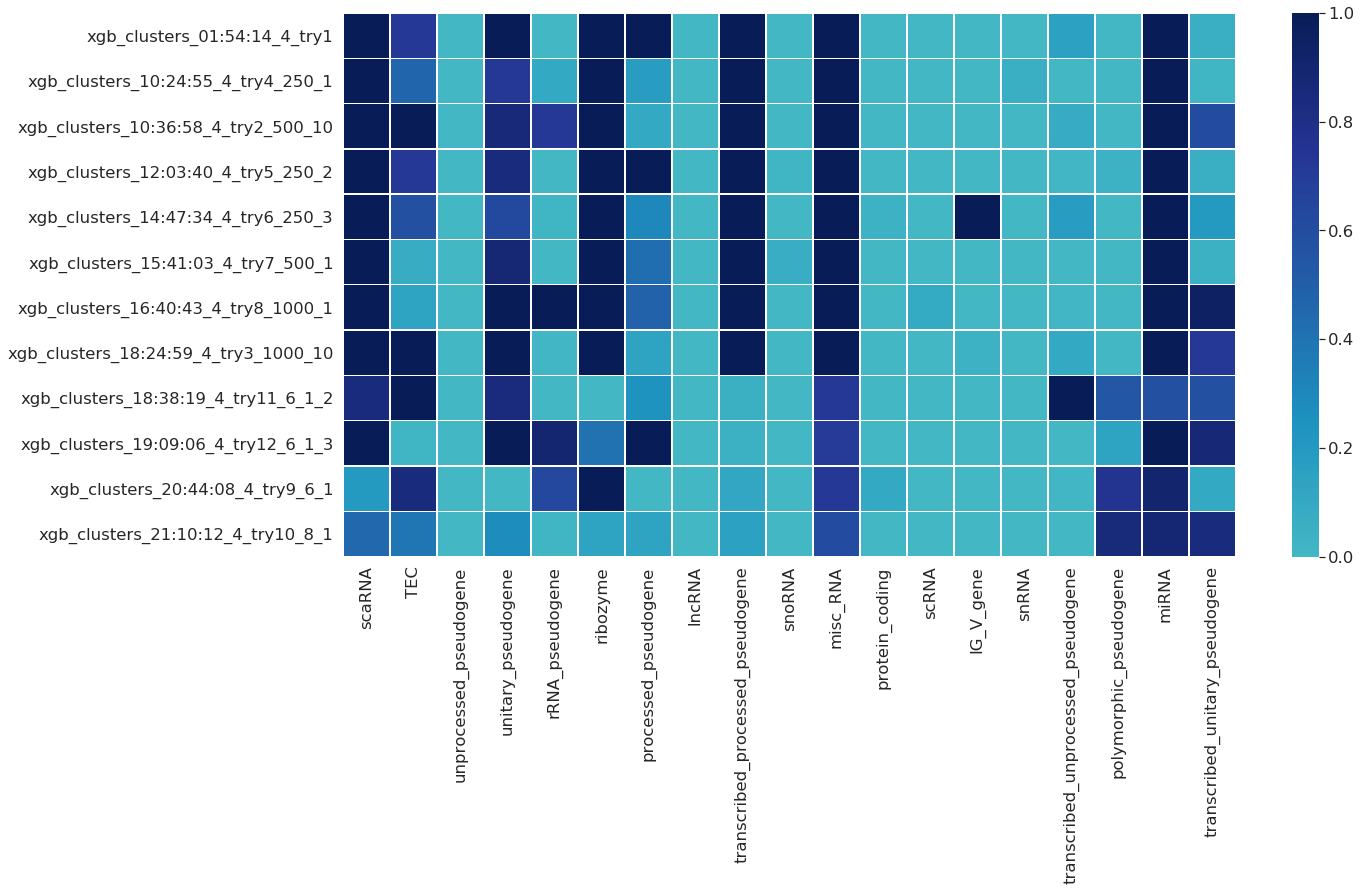

In [84]:
all_pval_clus_corr = np.array([all_pvals_clus[i] for i in all_pvals_clus.keys()])
all_pval_clus_corr = fdrcorrection(all_pval_clus_corr.flatten())[1].reshape(all_pval_clus_corr.shape)
all_pval_clus_corr = pd.DataFrame(all_pval_clus_corr, index = all_pvals_clus.keys(), columns = gene_types)

plt.figure(figsize = (20, 10))
sns.set(font_scale=1.5)
ax = sns.heatmap(all_pval_clus_corr, center = 0.01, vmin=0, vmax=1, linewidths=.5, cmap="YlGnBu")
plt.show()

In [30]:
all_pvals_trpr = {}

In [32]:
for modelname in modelnames_trpr:
    if not modelname:
        continue
    bst = xgb.Booster({'nthread': 10})
    bst.load_model('/home/pitikovegor/CourseWork/genomes/models/%s' % modelname) 
    preds = bst.predict(full_kmers)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    best_preds
    preds_to_type = np.concatenate((best_preds[:, np.newaxis], all_kmers[:, 4][:, np.newaxis], all_kmers[:, 0][:, np.newaxis]), axis=1)
    gene_types = list(set(all_kmers[:, 4]))
    means = {}
    for i in gene_types:
        spec = np.count_nonzero((preds_to_type[:, 0] == 1) & (preds_to_type[:, 1] == i))
        nonspec = np.count_nonzero((preds_to_type[:, 0] == 0) & (preds_to_type[:, 1] == i))
        #print('%s have %s specific and %s nonspecific contacts' % (i, spec, nonspec))
        means[i] = [nonspec, spec]
    rna_types = list(means.keys())
    rna_types.sort()
    answ = []
    for i in rna_types:
        answ.append(fisher_exact(get_cov_matrix(means, i))[1])
    all_pvals_trpr[modelname] = answ

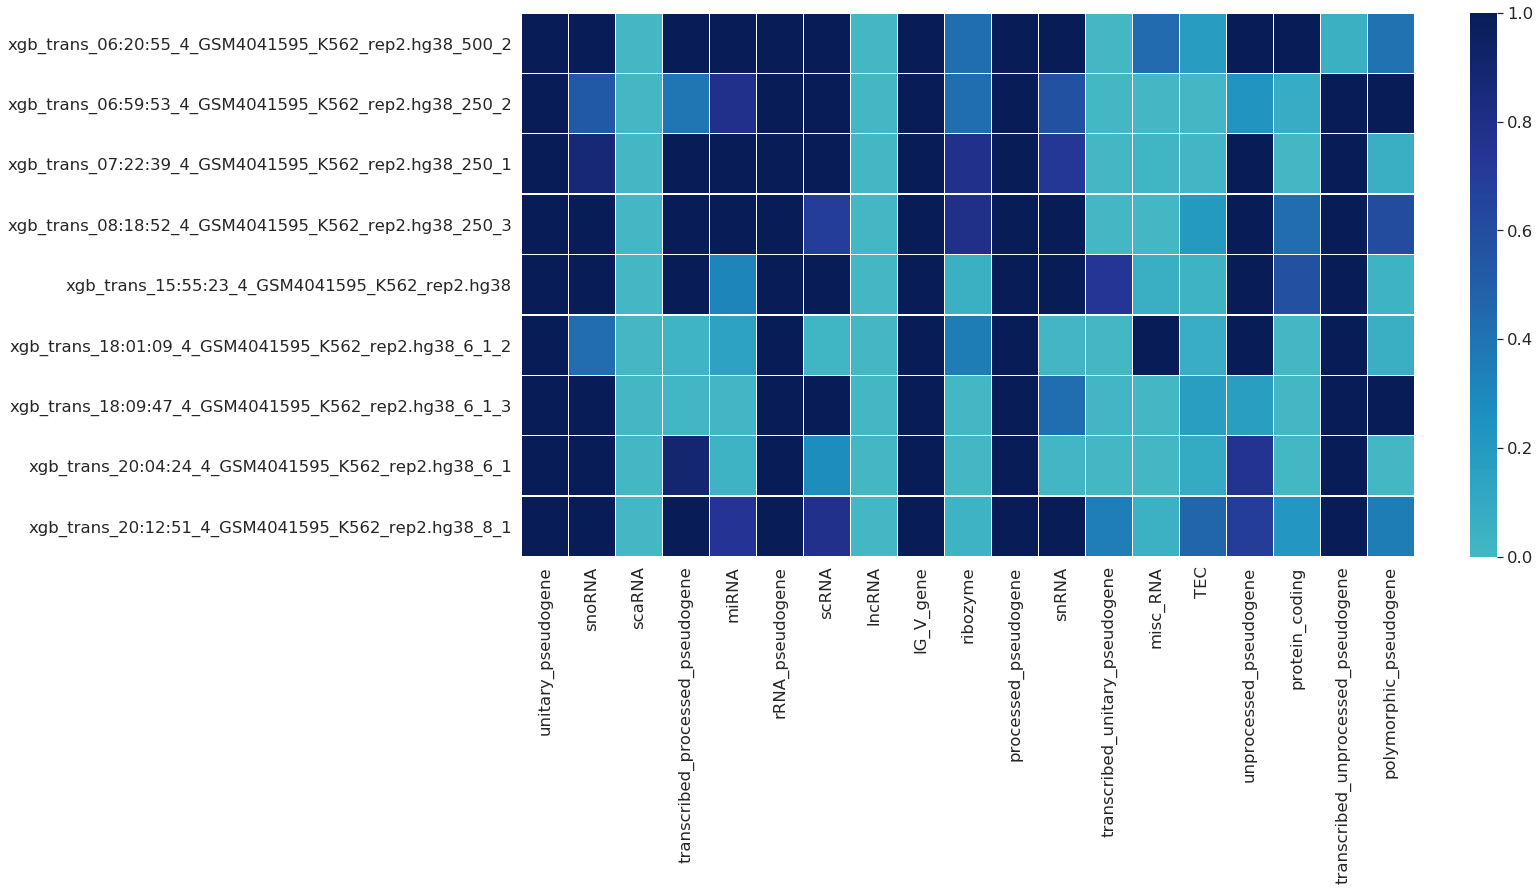

In [38]:
all_pvals_trpr_corr = np.array([all_pvals_trpr[i] for i in all_pvals_trpr.keys()])
all_pvals_trpr_corr = fdrcorrection(all_pvals_trpr_corr.flatten())[1].reshape(all_pvals_trpr_corr.shape)
all_pvals_trpr_corr = pd.DataFrame(all_pvals_trpr_corr, index = all_pvals_trpr.keys(), columns = gene_types)

plt.figure(figsize = (20, 10))
sns.set(font_scale=1.5)
ax = sns.heatmap(all_pvals_trpr_corr, center = 0.01, vmin=0, vmax=1, linewidths=.5, cmap="YlGnBu")
plt.show()